#### Бэктест торговой системы с различными коэффициентами и параметрами
<b>Описание торговой системы</b>
<br>Торговая система основана на анализе движения цены инструмента
<br><br>Тренд: 
<ul>
    <li>определяется движением цены в границах канала Per_Tr по умолчанию равного 0.2 процента, рассчитанного от цены последней сделки </li>
    <li>при пробитии верхней границы канала считаем тренд восходящим: Trend=1</li>
    <li>при пробитии нижней границы канала считаем тренд нисходящим: Trend=2</li>
</ul>
Вход в позицию: 
<ul>
    <li>при откате цены от максимума/минимума канала на величену коэффициента k_Ent, например, 0.1</li>
</ul>
Выход из позиции: 
<ul>
    <li>при достижении фиксированного уровня, определяемого коэффициентом k_Ext от уровня входа в позицию, например, 0.15</li>
    <li>при изменении тренда, т.е. при достижении ценой уровня минимума или максимума канала</li>
</ul>
<b>Общий пример:</b>

![image](images/backtest-trading-system.JPG)

#### Дополнительные параметры CTr и CTr_In
<ul>
    <li><b>CTr</b>: определяет, при каком по счету откате от маскимума при восходящем тренде и от минимума при нисходящем тренде был вход в позицию
    <br>Параметр CTr сбрасывается до значения 1 при изменении тренда
    <li><b>CTr_In</b>: определяет, какой по счету был вход в позицию в рамках канала Per_Tr не обновляя максимум/минимум
    <br>Параметр CTr_In сбрасывается до значения 1 при обновлении цены максимума\минимума канала Per_Tr или при изменении тренда


<b>Пример 1</b>: k_Ent`<`k_Ext - коэффициент входа в позицию меньше коэффициента выхода из позиции
<br>В данном примере параметр CTr является значимым, параметр CTr_In всегда будет равен 1
<br>Результаты трейдов можно категоризировать по параметру CTr
<br>Например, отдельно посчитать прибыль при CTr=1, при CTr=2 и т.д. до CTr=max
<br><br>На схеме обозначен подсчет параметра CTr в рамках одного тренда

![image](images/backtest-trading-system_CTr.JPG)

<b>Пример 2</b>: k_Ent`>=`k_Ext - коэффициент входа в позицию меньше коэффициента выхода из позиции
<br>В данном примере оба параметра - и CTr, и CTr_In являются значимымы
<br>Результаты трейдов можно категоризировать по обоим параметрам
<br>Например, отдельно посчитать прибыль при CTr=1 и CTr_In = от 1 до max, при CTr=2 и CTr_In = от 1 до max, и т.д. до CTr=max и CTr_In = от 1 до max
<br><br>На схеме обозначен подсчет параметров CTr и CTr_In в рамках одного тренда

![image](images/backtest-trading-system_CTr_In.JPG)

In [1]:
# Импортируем модули и функции
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from functions import f_round
from functions import f_ent_params
from functions import f_all_deals
from functions import f_dict_str_all_deals
from functions import f_stat1
from functions import f_plot_Str_id
from functions import f_group_by_stat
from functions import f_group_by_stat2
from functions import f_data_plot
from functions import f_group_by_stat_CTr
from functions import f_group_by_stat_CTr_CTr_In

#### Загружаем данные по инструменту для бэктеста
Данные по инструменту взяты с сайта https://www.finam.ru/ и сохранены в формате *.txt в репозитории в директории datasets
<br>В нашем примере рассматриваем график цены фьючерса Si доллар-рубль за даты 20220421 и 20220422
<br>Фьючерс Si торгуется на Московской бирже https://www.moex.com/ 

In [2]:
#create data files list
txtfiles = []
for file in glob.glob(".\\datasets\\*.txt"):
        txtfiles.append(file)
print(f'Название файлов с данными: \n{txtfiles}')
print('\nПервые пять строк из файла с данными:')
print(pd.read_csv(txtfiles[0],sep=','
                           ,names=['date','time','last','vol','id','oper'],header=0).head(5))

Название файлов с данными: 
['.\\datasets\\SiM2_Si-6.22_20220421.txt', '.\\datasets\\SiM2_Si-6.22_20220422.txt']

Первые пять строк из файла с данными:
       date    time     last  vol                   id oper
0  20220421  100000  78050.0    1  1892947264515604481    B
1  20220421  100000  78075.0    1  1892947264515604482    B
2  20220421  100000  78100.0    1  1892947264515604483    B
3  20220421  100000  78125.0    1  1892947264515604484    B
4  20220421  100000  78150.0    1  1892947264515604485    B


#### Создаем датафрейм с коэффициентами торгвой системы используя функцию df_ent_params()
Описание параметров функции:
<ul>
    <li><b>Per_Tr</b>: ширина торгового диапазона, равная по умолчанию 0.2 процента от текущей цены инструмента</li>
    <li><b>k_Ent_Step</b>: шаг для коэффициента уровня входа в позицию</li>
    <li><b>k_Ent_min</b>: минимальный коэффициент уровня входа</li>
    <li><b>k_Ent_max</b>: максимальный коэффициент уровня входя</li>
    <li><b>k_Ext_Step</b>: шаг для коэффициента уровня выхода из позиции</li>
    <li><b>k_Ext_min</b>: минимальный коэффициент уровня выхода</li>
    <li><b>k_Ext_min</b>: максимальный коэффициент уровня выхода</li>
</ul>
<br>Функция возвращает датафрейм с id торговых стратегий - <b>Str_id</b>, которым соответствуют определенные коэффициенты

In [3]:
#create dataframe with enter parameters
df_ent_params=f_ent_params.df_ent_params_func_All(Per_Tr=0.2,
                                         k_Ent_Step=0.05,
                                         k_Ent_min=0.05, k_Ent_max=0.15,
                                         k_Ext_Step=0.05,
                                         k_Ext_min=0.025, k_Ext_max=0.15 )
print(f'Датафрейм с id торговых стратегий: \n{df_ent_params}')

Датафрейм с id торговых стратегий: 
    Str_id  Per_Tr  k_Ent  k_Ext  k_Sl
0      1.0     0.2   0.05   0.03  0.15
1      2.0     0.2   0.05   0.08  0.15
2      3.0     0.2   0.05   0.12  0.15
3      4.0     0.2   0.10   0.03  0.10
4      5.0     0.2   0.10   0.08  0.10
5      6.0     0.2   0.10   0.12  0.10
6      7.0     0.2   0.10   0.17  0.10
7      8.0     0.2   0.15   0.03  0.05
8      9.0     0.2   0.15   0.08  0.05
9     10.0     0.2   0.15   0.12  0.05
10    11.0     0.2   0.15   0.17  0.05
11    12.0     0.2   0.15   0.22  0.05


#### Торговая логика с созданием итоговых таблиц
Собираем статистику перебирая в цикле все стратегии и данные по инструменту и выводим обрабатываемую итерацию
<br>Другими словами, считаем, каким бы был результат трейдов при использовании каждой из стратегий за каждый торговый день

In [4]:
# запускаем код из файла "trading_logic.py"
exec(open("trading_logic.py").read())

Str_id: 1   Per_Tr: 0.2   k_Ent=0.05   k_Ext=0.03   k_Sl=0.15
Str_id: 2   Per_Tr: 0.2   k_Ent=0.05   k_Ext=0.08   k_Sl=0.15
Str_id: 3   Per_Tr: 0.2   k_Ent=0.05   k_Ext=0.12   k_Sl=0.15
Str_id: 4   Per_Tr: 0.2   k_Ent=0.1   k_Ext=0.03   k_Sl=0.1
Str_id: 5   Per_Tr: 0.2   k_Ent=0.1   k_Ext=0.08   k_Sl=0.1
Str_id: 6   Per_Tr: 0.2   k_Ent=0.1   k_Ext=0.12   k_Sl=0.1
Str_id: 7   Per_Tr: 0.2   k_Ent=0.1   k_Ext=0.17   k_Sl=0.1
Str_id: 8   Per_Tr: 0.2   k_Ent=0.15   k_Ext=0.03   k_Sl=0.05
Str_id: 9   Per_Tr: 0.2   k_Ent=0.15   k_Ext=0.08   k_Sl=0.05
Str_id: 10   Per_Tr: 0.2   k_Ent=0.15   k_Ext=0.12   k_Sl=0.05
Str_id: 11   Per_Tr: 0.2   k_Ent=0.15   k_Ext=0.17   k_Sl=0.05
Str_id: 12   Per_Tr: 0.2   k_Ent=0.15   k_Ext=0.22   k_Sl=0.05


#### Выводим итоговые данные бэктеста в таблице и на графике по всем торговым стратегиям
Построим график итоговой статистики в разрезе коэффициентов торговой системы <b>k_Ent</b> и <b>k_Ext</b>
<br>Используем функцию <b>group_by_stat2()</b>
<br>Описание параметров функции <b>group_by_stat2()</b>:
<ul>
    <li><b>df_all_deals</b>: датафрейм со всеми сделками по всем стратегиям</li>
    <li><b>df_day_open</b>: датафрейм с торговыми днями</li>
    <li><b>column</b>: параметр вывода результата в таблицу</li>
    <ul>
        <li><b>Total</b>: количество пунктов, выигранных стратегией</li>
        <li><b>AVG_deal</b>: среднее количество пунктов, выигранных стратегией за один трейд</li>
    </ul>
    <li><b>CTr</b>: определяет, при каком по счету откате от маскимума при восходящем тренде и от минимума при нисходящем тренде был вход в позицию<br>Параметр <b>CTr</b> сбрасывается до значения 1 при изменении тренда<br>При CTr=0 функция возвращает все результаты</li>
    <li><b>CTr_In</b>: определяет, какой по счету был вход в позицию в рамках канала Per_Tr не обновляя максимум/минимум<br>Параметр CTr_In сбрасывается до значения 1 при обновлении цены максимума\минимума канала Per_Tr или при изменении тренда<br>При CTr_In=0 функция возвращает все результаты</li>
</ul>
<br>График <b>Profit summary statistic with different coefficients</b> выводит:
<ul>
    <li>по оси x: коэффициенты входа k_Ent в разрезе с коэффициентами выхода k_Ext</li>
    <li>по оси y: результат торговой стратегии Total или AVG_deal</li>
</ul>
<br><b><font color='green'>Установим параметры CTr=0 и CTr_In=0, чтобы вернуть все результаты</font></b>

    Str_id  k_Ent  k_Ext  Total  AVG_deal  Count  DrDown
0        1   0.05   0.03   9377  5.063175   1852   -1105
1        2   0.05   0.08  -3160 -3.119447   1013   -3476
2        3   0.05   0.12  -3090 -3.050346   1013   -5215
3        4   0.10   0.03   5815  4.490347   1295    -592
4        5   0.10   0.08   2571  4.425129    581    -750
5        6   0.10   0.12   1600  3.162055    506   -1159
6        7   0.10   0.17    986  1.948617    506   -2025
7        8   0.15   0.03   2410  3.217623    749    -558
8        9   0.15   0.08   2428  5.633411    431    -669
9       10   0.15   0.12   2147  5.914601    363    -689
10      11   0.15   0.17   1884  5.640719    334    -871
11      12   0.15   0.22   1927  5.769461    334    -965
0    20220421
1    20220422
Name: Date, dtype: object


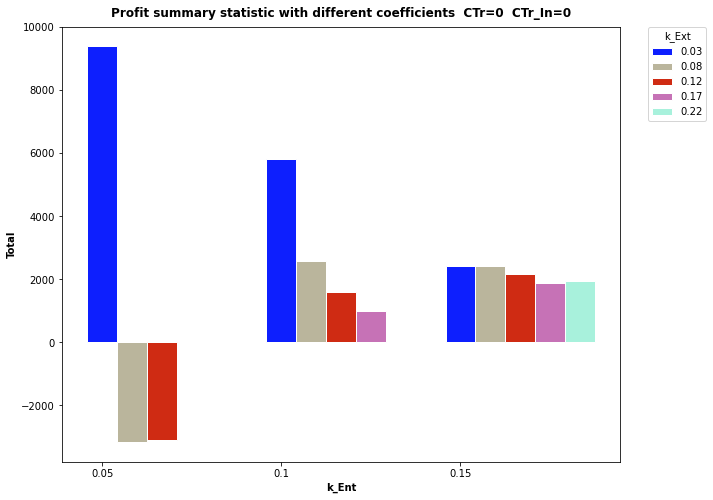

In [5]:
# Summary statistic with different coefficients
df_results=f_group_by_stat2.group_by_stat2(df_all_deals=df_all_deals
                                  , df_day_open=df_day_open
                                  , CTr=0
                                  , CTr_In=0
                                  , column='Total'#,column='AVG_deal'
                                  )

По графику <b>Profit summary statistic with different coefficients</b> видно, что наиболее прибылной оказалась торговая стратегия с коэффициентами <b>k_Ent=0.05</b> и <b>k_Ext=0.03</b>
<br>По таблице над графиком видно, что это торговая стратегия <b>Str_id=1</b> и ее результат составляет <b>Total=9377</b> пунктов
<br><br><b><font color='green'>Для стравнения построим аналогичный график, но в данном случае установим параметр CTr=1</font></b>

    Str_id  CTr  k_Ent  k_Ext  Total   AVG_deal  Count  DrDown
0        1    1   0.05   0.03   2190   5.093023    430   -1105
1        2    1   0.05   0.08    434   1.808333    240   -3476
2        3    1   0.05   0.12   2502  10.425000    240   -5215
3        4    1   0.10   0.03   4034   6.454400    625    -592
4        5    1   0.10   0.08   2755   9.945848    277    -750
5        6    1   0.10   0.12   3087  12.916318    239   -1159
6        7    1   0.10   0.17   3293  13.778243    239   -2025
7        8    1   0.15   0.03   1727   3.321154    520    -558
8        9    1   0.15   0.08   2464   7.922830    311    -669
9       10    1   0.15   0.12   2117   8.205426    258    -689
10      11    1   0.15   0.17   2127   8.936975    238    -871
11      12    1   0.15   0.22   2616  10.991597    238    -965
0    20220421
1    20220422
Name: Date, dtype: object


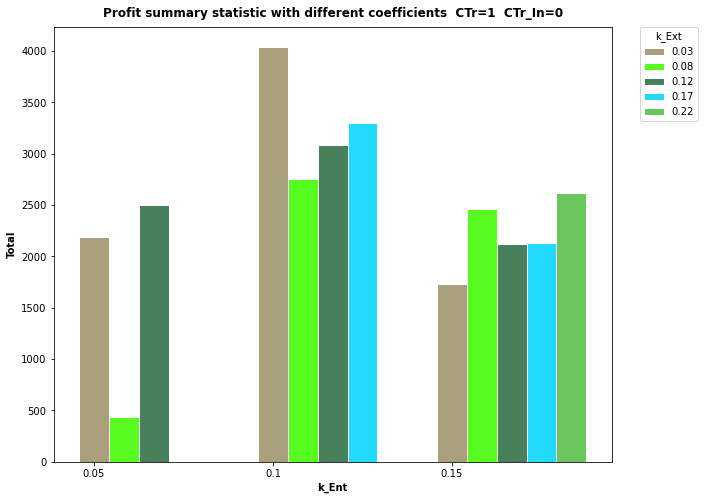

In [6]:
# Summary statistic with different coefficients CTr=1
df_results=f_group_by_stat2.group_by_stat2(df_all_deals=df_all_deals
                                  , df_day_open=df_day_open
                                  , CTr=1
                                  , CTr_In=0
                                  , column='Total'#,column='AVG_deal'
                                  )

#### Выберем id стратегии для более детального анализа и выведем его коэффициенты
Для примера, из итоговой таблицы результатов с параметрами CTr=0 и CTr_In=0 (первый график) выберем торговую стратегию с наименьшей просадкой <b>DrDown</b> и достаточно высоким показателем прибыли <b>Total</b>
<br>Торговая стратегия <b>Str_id=4</b> имеет наименьшую просадку <b>DrDown=-592</b> за количество трейдов <b>Count=1295</b> и итоговый результат <b>Total=5815</b> пунктов

In [7]:
# define Stratagie=Str_id for summary statistic
Str_id=4
print(df_ent_params[df_ent_params['Str_id']==Str_id])

   Str_id  Per_Tr  k_Ent  k_Ext  k_Sl
3     4.0     0.2    0.1   0.03   0.1


#### Построим кумулятивный график по выбранной торговой стратегии
Используем функцию <b>plot_Str_Id()</b>
<br>Параметры функции <b>plot_Str_Id()</b> аналогичны параметрам функции <b>group_by_stat2()</b>
<br><br>График <b>Backtest-trading-system result</b> выводит:
<ul>
    <li>по оси x: количество трейдов <b>Trades</b></li>
    <li>по оси y: кумулятивный результат трейдов <b>Total</b></li>
</ul>

   Str_id  Per_Tr  k_Ent  k_Ext  k_Sl  Str_id  Total  AVG_deal  Count  DrDown
0     4.0     0.2    0.1   0.03   0.1       4   5815  4.490347   1295    -597


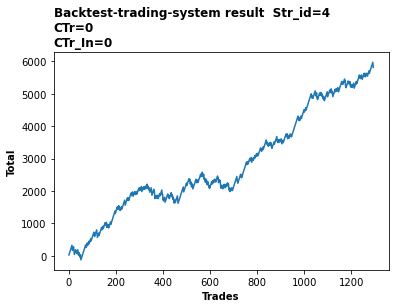

In [8]:
# строим по всем параметрам CTr и CTr_In, т.е. в функцию передаем значение 0 по этим параметрам
f_plot_Str_id.plot_Str_id(Str_id=Str_id
                ,df_ent_params=df_ent_params
                ,dict_str_all_deals=dict_str_all_deals
                ,CTr=0 ,CTr_In=0)

#### Построим график цены с визуальным отображением уровней входа и выхода для выбранного Str_id
Функция <b>data_plot()</b>
<ul>
<li>параметр <b>Str_id</b> определяет id торговой стратегии с ее коэффициентами</li>
<li>параметр <b>Date</b> определяет дату, за которую будет постоен график</li>
<li>параметр <b>conunt_deals</b> определяет кол-во сделок, которое отобразится на графике</li>
<li>параметр <b>deal_indx</b> определяет с какой сделки строить график</li>
</ul>
Примеры:
<ul>
<li>count_deals=10 и deal_index=0 выведет в таблицу и на график 10 сделок начиная с первой</li>
<li>count_deals=5 и deal_index=5 выведет в таблицу и на график 5 сделок начиная с шестой</li> 
</ul>


   Ent_time  Ext_time  Ent_Lvl  Ext_Lvl  Sl_Lvl  TP  SL  CTr  CTr_In  Tr
0    100140    100142    77752    77775   77673  23   0    1       1   1
1    100217    100220    77810    77833   77731  23   0    2       1   1
2    100228    100228    77810    77833   77731  23   0    2       2   1
3    100229    100230    77810    77833   77731  23   0    2       3   1
4    100230    100230    77810    77833   77731  23   0    2       4   1
5    100231    100233    77810    77833   77731  23   0    2       5   1
6    100235    100238    77810    77833   77731  23   0    2       6   1
7    100252    100254    77810    77833   77731  23   0    2       7   1
8    100254    100302    77810    77833   77731  23   0    2       8   1
9    100305    100341    77810    77833   77731  23   0    2       9   1


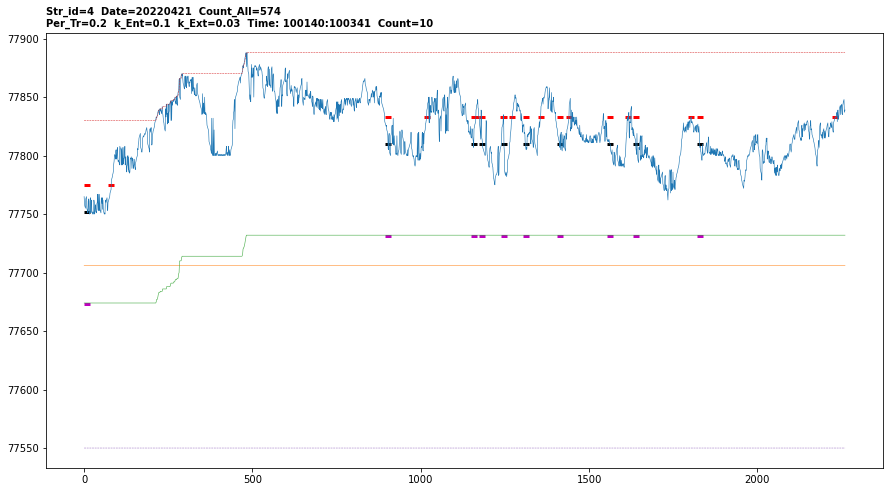

In [11]:
# plot deals with strategie = Str_id and Date = date
# show first 10 deals
np_df_day,df_deals=f_data_plot.data_plot( df_ent_params=df_ent_params
                                 ,dict_str_data=dict_str_data
                                 ,dict_str_deals=dict_str_deals
                                 ,Str_id=Str_id 
                                 ,Date=str(df_day_open['Date'][0])
                                 ,count_deals=10
                                 ,deal_indx=0 )

#### Построим график итоговой статистики в разрезе параметров торговой системы CTr и CTr_In
Параметры функции <b>group_by_stat_CTr_CTr_In()</b> аналогичны параметрам функции <b>group_by_stat2()</b>
<br><br>График <b>CTr and CTr_In summary statistic</b> выводит:
<ul>
    <li>по оси x значение параметра CTr в разрезе параметра CTr_In</li>
    <li>по оси x результат торговой стратегии Total или AVG_deal</li>
</ul>

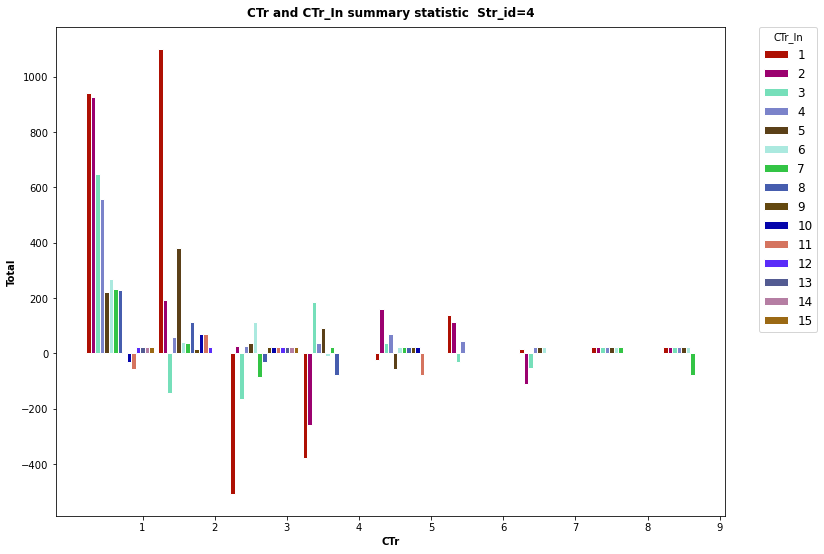

In [12]:
f_group_by_stat_CTr_CTr_In.group_by_stat_CTr_CTr_In( Str_id=Str_id
                                  , df_ent_params=df_ent_params
                                  , dict_str_all_deals=dict_str_all_deals
                                  , df_all_deals=df_all_deals
                                  ,column='Total'#, column='AVG_deal'
                                  )

<b>Вывод относительно графика "CTr and CTr_In summary statistic"</b>
<br>По графику видно, что большая часть трейдов приходится на CTr=1, CTr=2 и CTr=3
<br>Также видно, что максимальное количество входов в позицию в рамках канала Per_Tr не обновляя максимум/минимум было CTr_In=15


#### Построим график итоговой статистики в разрезе параметра торговой системы CTr
Параметры функции <b>group_by_stat_CTr()</b> аналогичны параметрам функции <b>group_by_stat2()</b>
<br><br>График <b>CTr summary statistic</b> выводит:
<ul>
    <li>по оси x значение параметра CTr</li>
    <li>по оси x результат торговой стратегии Total или AVG_deal</li>
</ul>


   CTr  Total   AVG_deal  DrDown  Count
0    1   4034   6.454400    -592    625
1    2   1961   5.477654    -597    358
2    3   -426  -2.645963    -498    161
3    4   -385  -5.422535    -443     71
4    5    224   6.222222    -420     36
5    6    267  16.687500    -374     16
6    7    -82  -5.857143    -382     14
7    8    161  23.000000       0      7
8    9     61   8.714286     -77      7


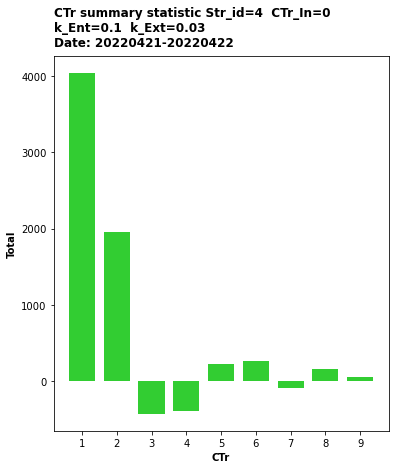

In [13]:
f_group_by_stat_CTr.group_by_stat_CTr( dict_str_all_deals=dict_str_all_deals
                           , df_all_deals=df_all_deals 
                           , df_day_open=df_day_open
                           , df_ent_params=df_ent_params
                           , Str_id=Str_id
                           , CTr_In=0
                           , column='Total' #, column='AVG_deal'
                           )

<br>По графику <b>CTr summary statistic</b> видно, что значение параметров CTr=1 и CTr=2 приносят самую высокую прибыль, в то время как при CTr`>`2 результаты становятся не стабильны
<br>Делаем вывод, что использовать торговую стратегию Str_id=4 для достижения максимальной прибыли предпочтительнее при значении CTr`<`3
<br><b>Для более наглядного представления построим графики кумулятивной прибыли при CTr=1 и CTr=2</b>

   Str_id  Per_Tr  k_Ent  k_Ext  k_Sl  Str_id  Total  AVG_deal  Count  DrDown
0     4.0     0.2    0.1   0.03   0.1       4   4034    6.4544    625    -533


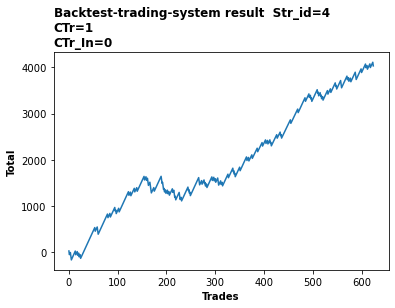

   Str_id  Per_Tr  k_Ent  k_Ext  k_Sl  Str_id  Total  AVG_deal  Count  DrDown
0     4.0     0.2    0.1   0.03   0.1       4   1961  5.477654    358    -478


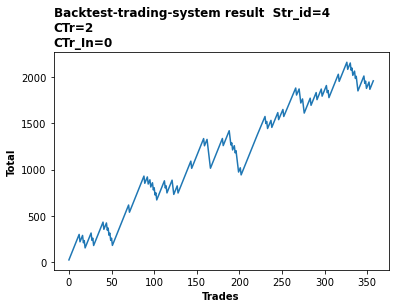

In [14]:
# строим с параметром CTr=1
f_plot_Str_id.plot_Str_id(Str_id=Str_id
                ,df_ent_params=df_ent_params
                ,dict_str_all_deals=dict_str_all_deals
                ,CTr=1 ,CTr_In=0)
# строим с параметром CTr=2
f_plot_Str_id.plot_Str_id(Str_id=Str_id
                ,df_ent_params=df_ent_params
                ,dict_str_all_deals=dict_str_all_deals
                ,CTr=2 ,CTr_In=0)

С параметрами CTr=1 и CTr=2 при количестве трейдов Count=625 и Count=358 соответственно видим стабильную прибыль
<br><b>Вывод:</b>
<br>Для достижения максимальной прибыли использовать торговую стратегию Str_id=4 предпочтительнее с параметрами CTr=1 и CTr=2

#### Итог
В данном бэктесте торговой системы с различными коэффициентами и параметрами было достигнуто следующее:
<br>
<ul>
    <li>разобрана логика торговой системы</li>
    <li>получены результаты нескольких прибыльных торговых стратегий</li>
    <li>детально проанализирована одна из наиболее выгрышных стратегий</li>
    <li>выбраны наиболее подходящие параметры, позволившые улучшить показатели стратегии</li>
</ul>